# 2. Road Detection: Image Processing

In this notebook, we use image processing steps to clean up difference image and detect real change in roads.

The difference image shows real differences (new / removed roads) as well as noise. We want to remove the noise so that only real change remains. In this notebook, we accomplish this through image processing techniques. First, we utilize [morphological transformations](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html) to clean up the speckle noise, then we find connected regions of pixels and filter these regions by minimum pixel count.

NOTE: The classified and source images are downloaded in the previous notebook.

## Notebook setup

In [271]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import rasterio
from rasterio.enums import Resampling
from rasterio.plot import show
import scipy
from scipy import ndimage

### Identify Downloaded Datasets

These datasets are downloaded in the previous notebook in this series.

In [168]:
# classified images
filename = 'data/1175-1272_2017-08-01.tif'
filename2 = 'data/1175-1272_2019-07-01.tif'

# source images
src_filename = 'data/source/1175-1272_2017-08-01.tif'
src_filename2 = 'data/source/1175-1272_2019-07-01.tif'

### Open and Visualize Subregion of Imagery

In [276]:
def _open(filename, factor=1):
    with rasterio.open(filename) as dataset:
        height = int(dataset.height / factor)
        width = int(dataset.width / factor)
        data = dataset.read(
            out_shape=(dataset.count, height, width)
        )
    return data

def open_bool(filename, factor=1):
    data = _open(filename, factor=factor)
    return data[0,:,:].astype(bool)

def open_rgb(filename, factor=1):
    data = _open(filename, factor=factor)
    return data[:3,:,:]

def get_figsize(factor):
    return tuple(2 * [int(25/factor)])

factor = 1
# figsize = get_figsize(factor)
figsize = (10, 10)
figsize

(10, 10)

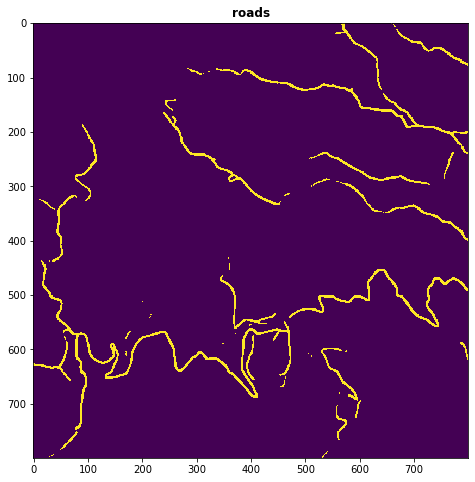

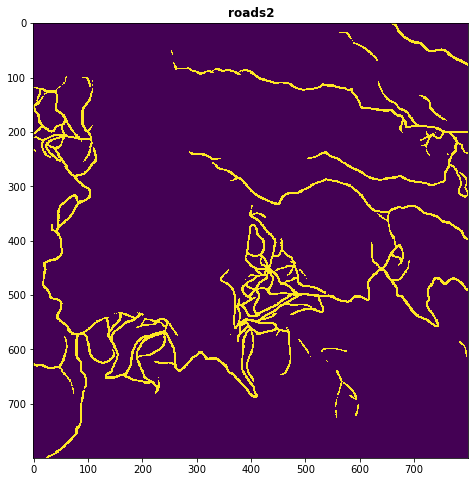

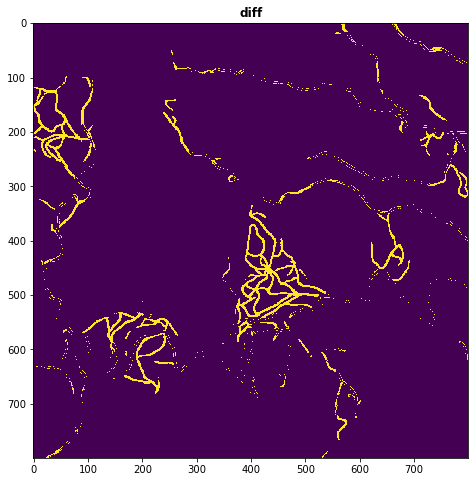

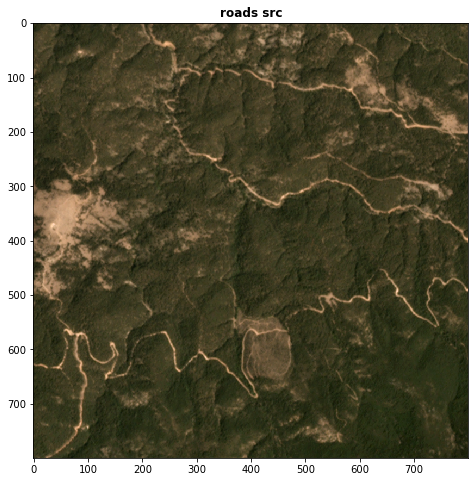

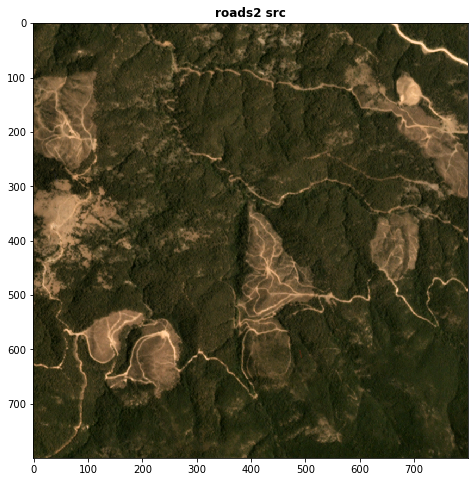

In [285]:
def get_subset(image, rmin, rmax, cmin, cmax, factor=1):
    if len(image.shape) == 3:
        img = image[:, int(rmin/factor):int(rmax/factor), int(cmin/factor):int(cmax/factor)]
    elif len(image.shape) == 2:
        img = image[int(rmin/factor):int(rmax/factor), int(cmin/factor):int(cmax/factor)]
    return img
        

sub_factor = 1
rmin, rmax, cmin, cmax = (700, 1500, 2700, 3500)
# rmin, rmax, cmin, cmax = (0, 1000, 0, 1000)
# rmin, rmax, cmin, cmax = (0, 1000, 3000, 4000)

roads = open_bool(filename, factor=factor)
roads_subset = get_subset(open_bool(filename), rmin, rmax, cmin, cmax)
roads2_subset = get_subset(open_bool(filename2), rmin, rmax, cmin, cmax)

# diff_subset = roads_subset.astype(np.int8) - roads2_subset.astype(np.int8)
diff_subset = np.bitwise_xor(roads_subset, roads2_subset)

src_subset = get_subset(open_rgb(src_filename), rmin, rmax, cmin, cmax)
src2_subset = get_subset(open_rgb(src_filename2), rmin, rmax, cmin, cmax)

sub_figsize = (8, 8)
fig = plt.figure(figsize=sub_figsize)
show(roads_subset, title="roads")
fig = plt.figure(figsize=sub_figsize)
show(roads2_subset, title="roads2")
fig = plt.figure(figsize=sub_figsize)
show(diff_subset, title="diff")
fig = plt.figure(figsize=sub_figsize)
show(src_subset, title="roads src")
fig = plt.figure(figsize=sub_figsize)
show(src2_subset, title="roads2 src")

## Morphological Transformations

In this section, we use the [morphological opening transformation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#opening), which first erodes the white (difference) pixels then dilates the white pixels. Effectively, this removes small or thin clusters of pixels identified as noise but doesn't change larger clusters.

In [286]:
diff = diff_subset

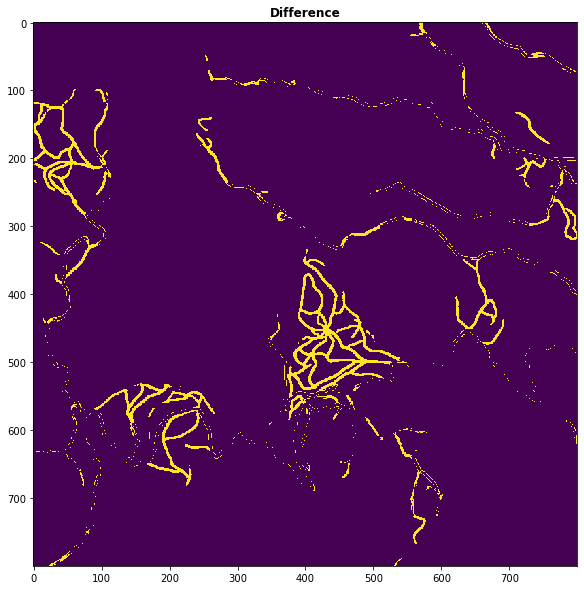

In [287]:
fig = plt.figure(figsize=figsize)
show(diff, title="Difference")

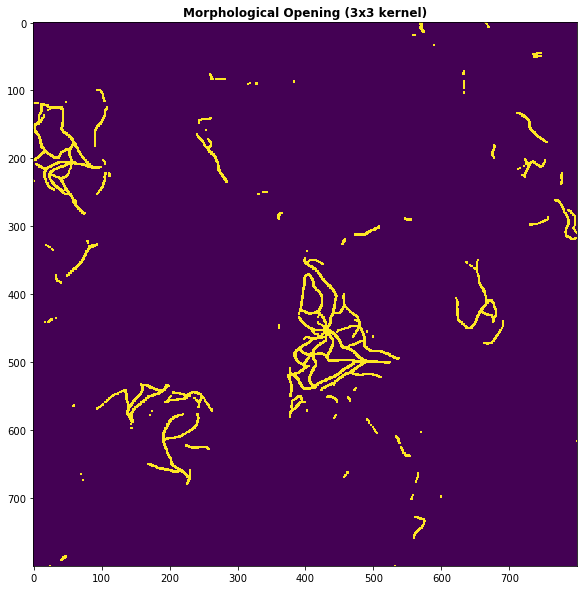

In [288]:
fig = plt.figure(figsize=figsize)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(diff.astype(np.uint8), cv2.MORPH_OPEN, kernel)
show(opening, title="Morphological Opening (3x3 kernel)")

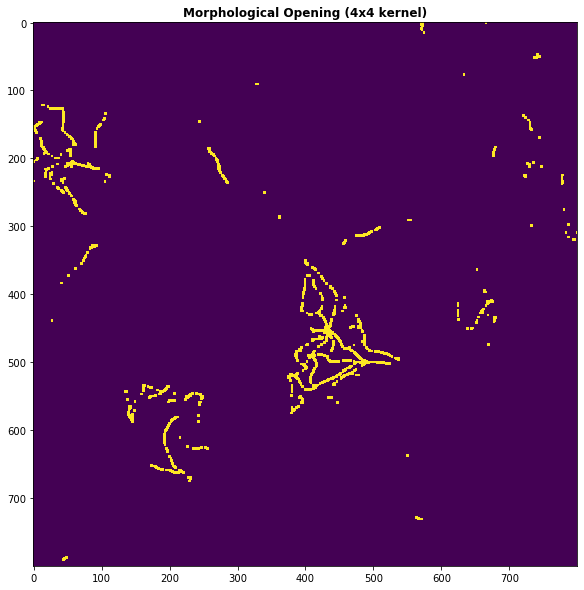

In [289]:
fig = plt.figure(figsize=figsize)
kernel = np.ones((4,4),np.uint8)
opening = cv2.morphologyEx(diff.astype(np.uint8), cv2.MORPH_OPEN, kernel)
show(opening, title="Morphological Opening (4x4 kernel)")

It appears the kernel size that removes noise but keeps the roads change is 3x3.

In [290]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(diff.astype(np.uint8), cv2.MORPH_OPEN, kernel)

## Filtering by Cluster Size

Now we will remove small clusters of difference pixels by separating out each cluster and filtering by an experimentally-determined minimum number of pixels in the cluster.

In [291]:
labeled = ndimage.label(opening)
labeled_img = labeled[0]

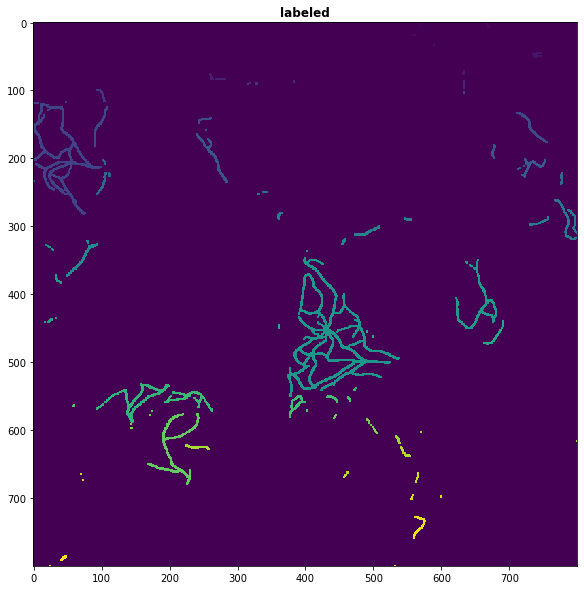

In [292]:
fig = plt.figure(figsize=figsize)
show(labeled_img, title="labeled")

In [293]:
# remove background and find pixel count for each label
labels = np.unique(labeled_img)[1:]
counts = [np.count_nonzero(labeled_img == l) for l in labels]
len(labels)

87

In [294]:
# print(sorted(counts, reverse=True))
filtered_counts = [c for c in counts if c > 100]
print(sorted(filtered_counts, reverse=True))

[5857, 2626, 1080, 999, 922, 544, 444, 309, 307, 282, 282, 279, 269, 190, 182, 179, 147, 141, 138, 117, 102]


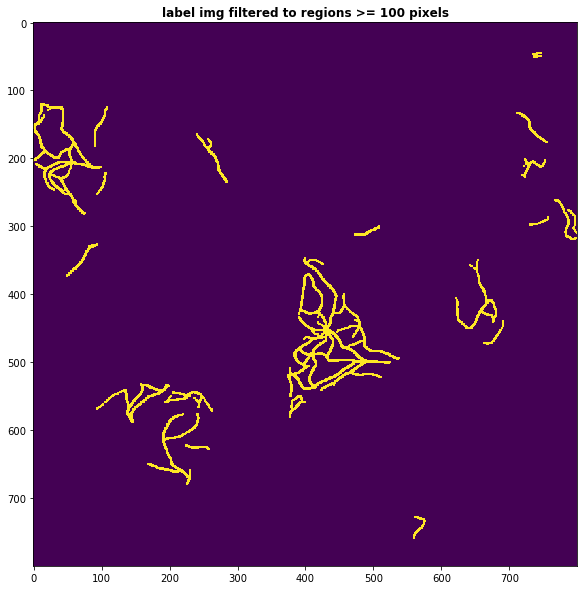

In [295]:
# filter by minimum pixel count
min_count = 100
filtered_regions = [l for (l, c) in zip(labels, counts) if c >= min_count]
len(filtered_regions)

filtered_label_img = np.zeros(labeled_img.shape)
for l in filtered_regions:
    filtered_label_img[labeled_img == l] = 1

fig = plt.figure(figsize=figsize)
show(filtered_label_img, title="label img filtered to regions >= {} pixels".format(min_count))

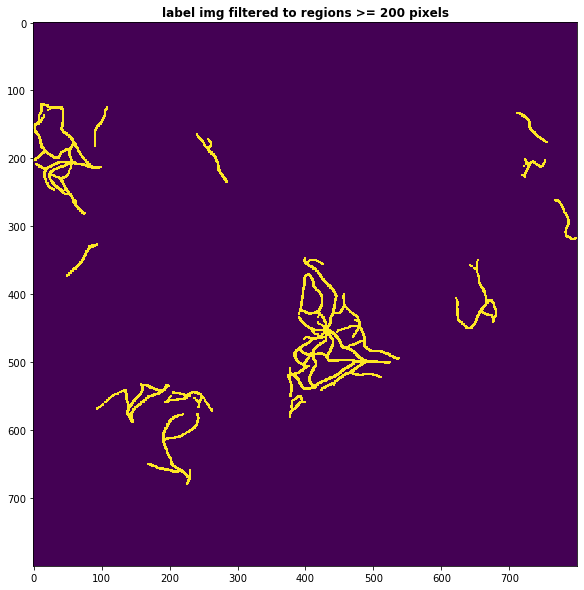

In [296]:
# filter by minimum pixel count
min_count = 200
filtered_regions = [l for (l, c) in zip(labels, counts) if c >= min_count]
len(filtered_regions)

filtered_label_img = np.zeros(labeled_img.shape)
for l in filtered_regions:
    filtered_label_img[labeled_img == l] = 1

fig = plt.figure(figsize=figsize)
show(filtered_label_img, title="label img filtered to regions >= {} pixels".format(min_count))

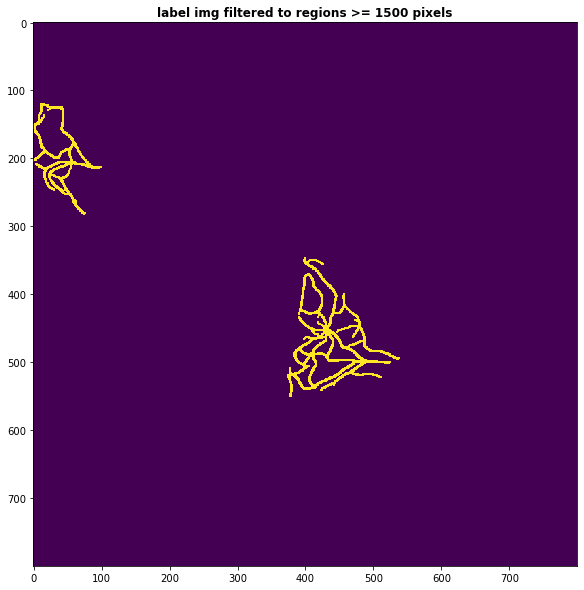

In [297]:
# filter by minimum pixel count
min_count = 1500
filtered_regions = [l for (l, c) in zip(labels, counts) if c >= min_count]
len(filtered_regions)

filtered_label_img = np.zeros(labeled_img.shape)
for l in filtered_regions:
    filtered_label_img[labeled_img == l] = 1

fig = plt.figure(figsize=figsize)
show(filtered_label_img, title="label img filtered to regions >= {} pixels".format(min_count))

While filtering to regions greater than 100 pixels still seems to keep some insignificant change, filtering to regions greater than 1500 pixels removes some significant change. Filtering to regions greater than 200 pixels seems to strike a balance that keeps the significant change while filtering out the noise.

## Entire Image

Now we apply the same filtering process across the entire image, using a 3x3 kernel for morphological opening and filtering to regions greater than 200 pixels.

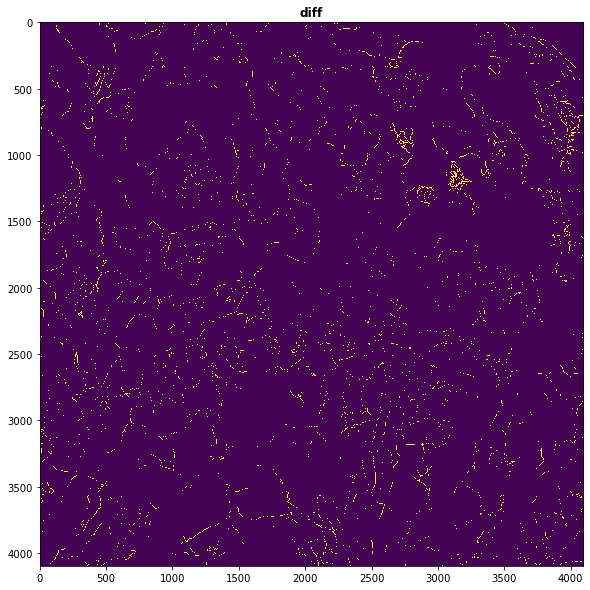

In [298]:
roads = open_bool(filename, factor=factor)
roads2 = open_bool(filename2, factor=factor)
diff = np.bitwise_xor(roads, roads2)

fig = plt.figure(figsize=figsize)
show(diff, title="diff")

In [299]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(diff.astype(np.uint8), cv2.MORPH_OPEN, kernel)

labeled = ndimage.label(opening)
labeled_img = labeled[0]

In [300]:
# remove background and find pixel count for each label
labels = np.unique(labeled_img)[1:]
counts = [np.count_nonzero(labeled_img == l) for l in labels]
len(labels)

1885

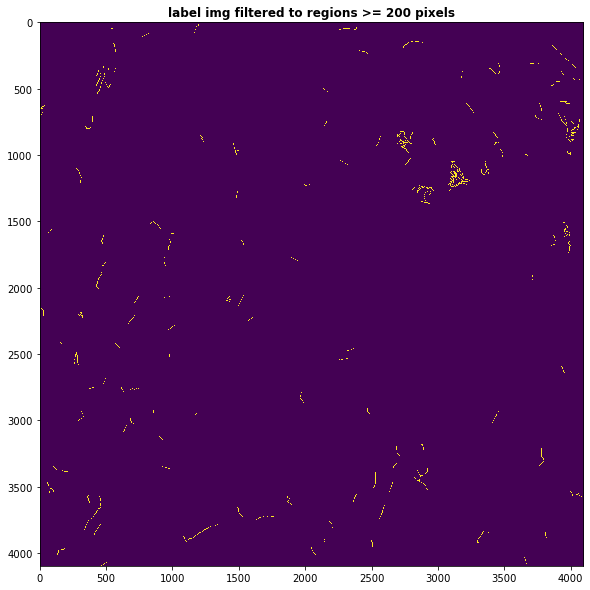

In [301]:
# filter by minimum pixel count
min_count = 200
filtered_regions = [l for (l, c) in zip(labels, counts) if c >= min_count]
len(filtered_regions)

filtered_label_img = np.zeros(labeled_img.shape)
for l in filtered_regions:
    filtered_label_img[labeled_img == l] = 1

fig = plt.figure(figsize=figsize)
show(filtered_label_img, title="label img filtered to regions >= {} pixels".format(min_count))

By zooming into various regions (accomplished in this notebook by changing the subregion limits), the change detected across this processed image is an accurate representation of the change in roads between the two images.

### Conclusion

This notebook presents a technique for finding changes in results from the Analytics API Road Detection feed by utilizing image processing techniques.